# Work in progress: py_sudoku

In [1]:
import numpy as np
import pandas as pd
import os

import cv2
import operator
from skimage.transform import  resize #, rescale, downscale_local_mean
from skimage import morphology

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
plt.figure(figsize=(15,15));

np.random.seed(0)

#Tensorflow
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPool2D

from livelossplot.tf_keras import PlotLossesCallback #  <= automatyczne tworzenie krzywej uczenia się

# https://github.com/HassanChaudary/Data-Augmentation-Arguments-keras--Explained/blob/master/Data-augmentation-Keras-Stepbystep.ipynb

# https://aishack.in/tutorials/sudoku-grabber-opencv-detection/
# https://mc.ai/sudoku-solver-using-opencv-and-dl%E2%80%8A-%E2%80%8Apart-1/
# https://towardsdatascience.com/open-cv-based-sudoku-solver-powered-by-rust-df256653d5b3

Using TensorFlow backend.


<Figure size 1080x1080 with 0 Axes>

In [3]:
# https://stackoverflow.com/questions/201461/shortest-sudoku-solver-in-python-how-does-it-work
#  refactored to Python 3

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0:
            if i == 0:
                print(" ┎─────────┰─────────┰─────────┒")
            else:
                print(" ┠─────────╂─────────╂─────────┨")

        for j in range(len(bo[0])):
            if j % 3 == 0:
                print(" ┃ ", end=" ")

            if j == 8:
                print(bo[i][j], " ┃")
            else:
                print(bo[i][j], end=" ")

    print(" ┖─────────┸─────────┸─────────┚")   
    
def same_row(i,j): return (i//9 == j//9)
def same_col(i,j): return (i-j) % 9 == 0
def same_block(i,j): return (i//27 == j//27 and i%9//3 == j%9//3)

def r(a):
    i = a.find('0')
    if i == -1:
        l = list(a)
        n = 9
        print_board([list(i) for i in zip(*[l[i:i+n] for i in range(0, len(l), n)])])
#         print_board(a)
#         sys.exit(a)

    excluded_numbers = set()
    for j in range(81):
        if same_row(i,j) or same_col(i,j) or same_block(i,j):
            excluded_numbers.add(a[j])

    for m in '123456789':
        if m not in excluded_numbers:
          # At this point, m is not excluded by any row, column, or block, so let's place it and recurse
            r(a[:i]+m+a[i+1:])

         
            
%time r(r'900006050400000000070009063200080000000000491000300000010050000502090000008701002')
# l = list('900006050400000000070009063200080000000000491000300000010050000502090000008701002')
# n = 9
# print_board([list(i) for i in zip(*[l[i:i+n] for i in range(0, len(l), n)])])


 ┎─────────┰─────────┰─────────┒
 ┃  9 4 1  ┃  2 8 6  ┃  7 5 3  ┃
 ┃  2 8 7  ┃  4 3 5  ┃  1 6 9  ┃
 ┃  3 6 5  ┃  1 7 9  ┃  4 2 8  ┃
 ┠─────────╂─────────╂─────────┨
 ┃  1 5 8  ┃  9 6 3  ┃  2 4 7  ┃
 ┃  7 3 4  ┃  8 2 1  ┃  5 9 6  ┃
 ┃  6 2 9  ┃  7 5 4  ┃  3 8 1  ┃
 ┠─────────╂─────────╂─────────┨
 ┃  8 1 2  ┃  6 4 7  ┃  9 3 5  ┃
 ┃  5 7 6  ┃  3 9 2  ┃  8 1 4  ┃
 ┃  4 9 3  ┃  5 1 8  ┃  6 7 2  ┃
 ┖─────────┸─────────┸─────────┚
Wall time: 6.1 s


Width:  2039 Height:  2118


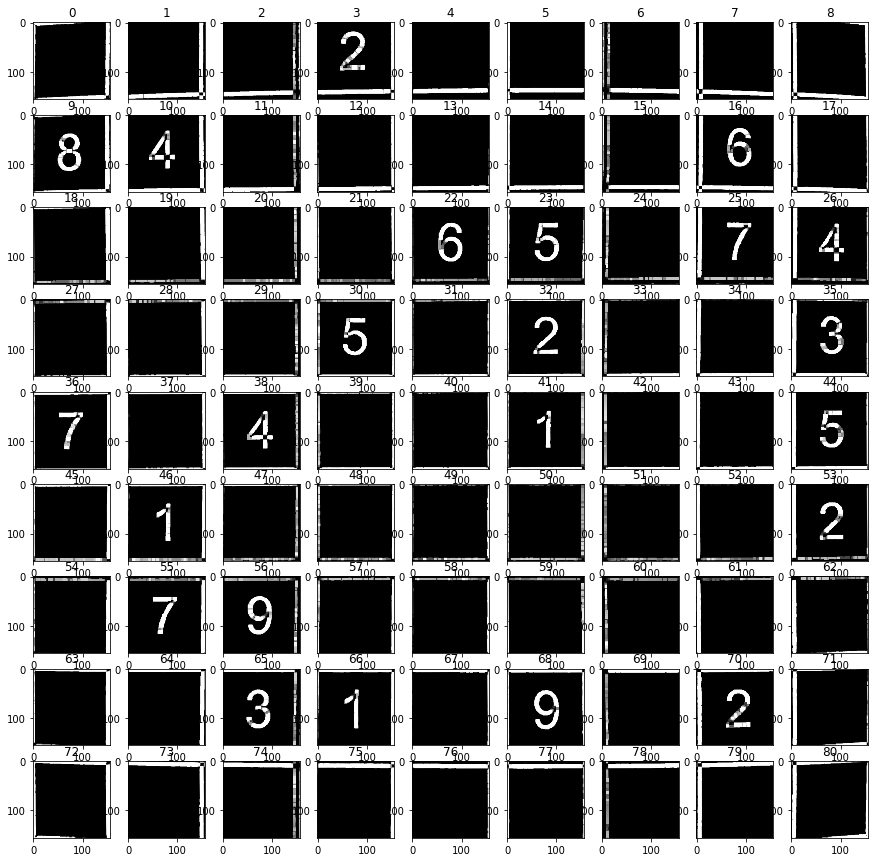

In [16]:
# rewritten code from next cells:

def order_points(pts):
    # rect =  [top-left,
    #          top-right, 
    #          bottom-right,
    #          bottom-left]
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    print('Width: ', maxWidth, 'Height: ', maxHeight)
    
    # perespective transformation
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warped_r = cv2.resize(warped, (1404, 1404))
    
    return warped_r

def extract_board(file_path):
    image = cv2.imread(file_path)
    image = cv2.GaussianBlur(image, (11, 11), 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
    image = cv2.bitwise_not(image, image)
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
    image = cv2.dilate(image, kernel)
    
    contours, h = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    polygon = contours[0]
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in  polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in  polygon]), key=operator.itemgetter(1))

    crop_rect=[polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]
    
    pts = np.asarray(crop_rect)
    
    return four_point_transform(image, pts)


def crop_squares(image):  
    num = np.zeros((81, 156,156), dtype = "float32")
    h = 156
    w = 156
    k = 0
    
    mask = np.array(Image.open('mask.png').resize(num[0].shape[1::-1], Image.BILINEAR))
    mask = mask / 255
    
    for y in range(9):
        for x in range(9):
            #print(k,'|', y*156, (y+1)*h, x*156, (x+1)*w)
            num[k] = image[y*156:(y+1)*h, x*156:(x+1)*w] # [0:156, 0,156]
            
            kernel = np.ones((5,5),np.uint8)
            num[k] = cv2.morphologyEx(num[k], cv2.MORPH_OPEN, kernel)
            #cv2.floodFill(num[k], None, (7,7), 0, 10, 50)
#             num[k] = num[k] * mask
            k += 1

    return num
            
def remove_borders():
    pass

def plot_boxes(num):
    fig = plt.figure(figsize=(15, 15))
    for idx in range(81):
        plt.subplot(9,9,idx+1)
        plt.imshow(num[idx], cmap='gray', interpolation='none')
        plt.title(idx)
        
# -------------------------------------------

# fix image size: 1404 x 1404
board = extract_board(r'./src/2.jpg')
single_digits = crop_squares(board.copy())  
plot_boxes(single_digits)

# https://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html

## Wyznaczenie punktów skrajnych

Przetwarzanie obrazu sudoku - krok pierwszy - wykrycie największego kawdaratu, bedą cego plansza gry. 

[ 54 147] [1442  148] [1441 1615] [  50 1613]


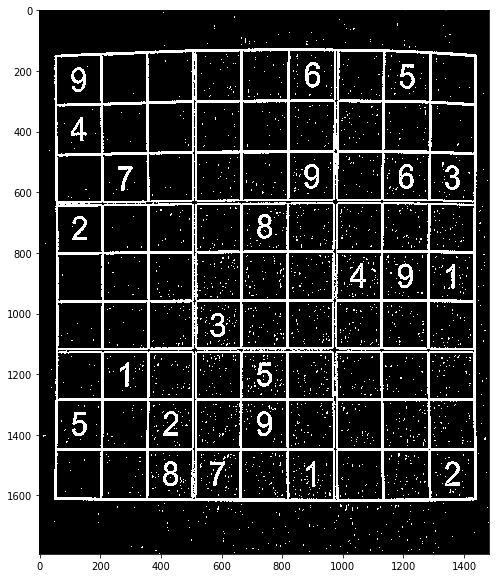

In [5]:
# read image
image = cv2.imread('./src/1.jpg')

# gaussian blur
image = cv2.GaussianBlur(image, (11, 11), 0)

# convert to gray
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# image treshold - isolates objects by converting grayscale images into binary images
image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)

#invert the image colours
image = cv2.bitwise_not(image, image)

# sharpening
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
image = cv2.dilate(image, kernel)

# detect edges
# edged = cv2.Canny(image, 30, 200)

# find countours
contours, h = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]

bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in  polygon]), key=operator.itemgetter(1))
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in  polygon]), key=operator.itemgetter(1))

crop_rect=[polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

print(crop_rect[0],crop_rect[1], crop_rect[2], crop_rect[3])

# 1.jpg
# top-left:[54 147]
# top-right: [50 1613]
# bottom-right: [1441 1615]
# bottom-left: [1442  148]

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray');

## Transformacja perespektywy, przycięcie, skalowanie
Po wykryciu wierzchołków kwadratu następuje przycięcie obrazu i jego transformacja do kwadratu o określonym rozmiarze.

[[  54.  147.]
 [1442.  148.]
 [1441. 1615.]
 [  50. 1613.]]
Width:  1391 Height:  1467


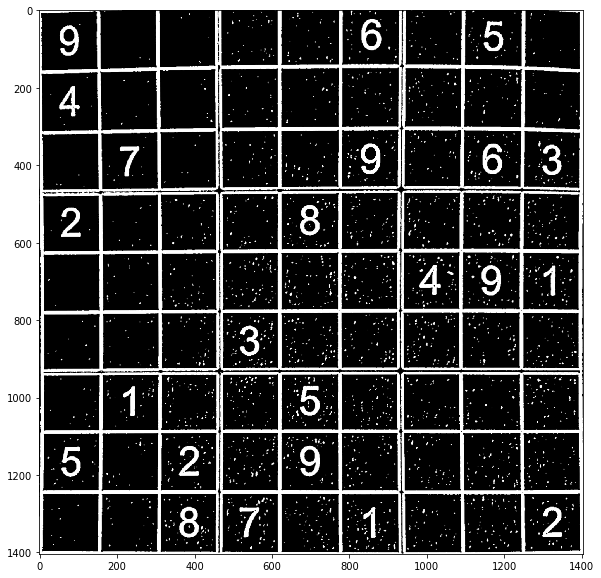

In [6]:
def order_points(pts):
    # rect =  [top-left,
    #          top-right, 
    #          bottom-right,
    #          bottom-left]
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    print(rect)
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    
    print('Width: ', maxWidth, 'Height: ', maxHeight)
    
    # perespective transformation
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # scaling
    warped_r = cv2.resize(warped, (1404, 1404))
    
    return warped_r


# crop_rect = [[54,147],[1442,148],[1441,1615],[50,1613]]
pts = np.asarray(crop_rect)

warped = four_point_transform(image, pts)
plt.figure(figsize=(10,10))
plt.imshow(warped, cmap='gray');

## Ekstrakcja pojedynczych pól
Kolejny krok - wycięcie z całego obrazu kwadratów o stałym rozmiarze(siatka 9x9)

In [7]:
image = warped.copy()
# cropped = image[0:0, 156:156]

num = np.zeros((81, 156,156), dtype = "float32")
print(num.shape)

h=156
w=156

def crop_squares(): 
    k=0
    for y in range(9):
        for x in range(9):
            #print(k,'|', y*156, (y+1)*h, x*156, (x+1)*w)
            num[k] = image[y*156:(y+1)*h, x*156:(x+1)*w] # [0:156, 0,156]
            
            kernel = np.ones((5,5),np.uint8)
            num[k] = cv2.morphologyEx(num[k], cv2.MORPH_OPEN, kernel)
            #cv2.floodFill(num[k], None, (7,7), 0, 10, 50)
            k += 1
           
crop_squares()           

# np.save('file.npz',num)

from PIL import Image
im = Image.fromarray(num[0])
im = im.convert("L")
# im.save("00.jpg")

(81, 156, 156)


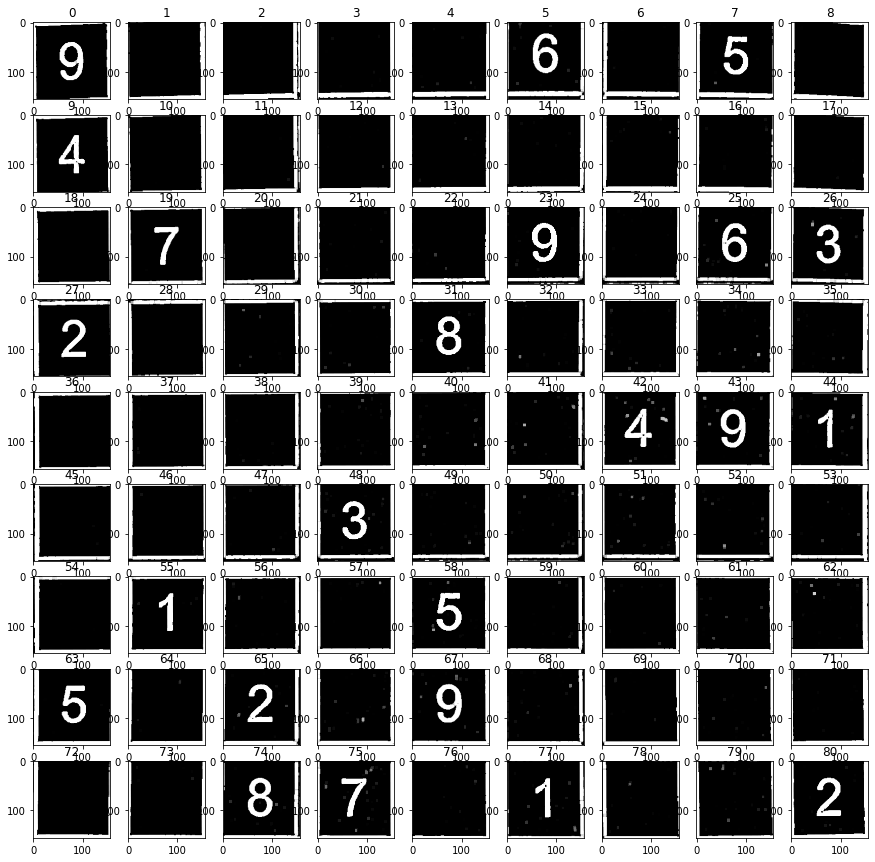

In [5]:
fig = plt.figure(figsize=(15, 15))
for idx in range(81):
    plt.subplot(9,9,idx+1)
    plt.imshow(num[idx], cmap='gray', interpolation='none')
    plt.title(idx)

Ręczne oznaczenie cyfr

In [6]:
no_id = {
    '0' : [1,2,3,4,8,37],
    '1' : [44,55,77],
    '2' : [27,65,80],
    '3' : [26,48],
    '4' : [9,42],
    '5' : [7,58,63],
    '6' : [5,25],
    '7' : [19,75],
    '8' : [31,74],
    '9' : [0,23,43,67]
}   

## Usunięcie ramek

Usubięcie obramowań jest zrobione w bardzo podstawowy sposób - poprzez nało żenie maski. W przyszłości trzebabędzie zastosować coś lepszego, może wystąpić sytuacja gdzie maska przytnie kawaek cyfry.

(156, 156)
float64 0.0 0.9607843137254902


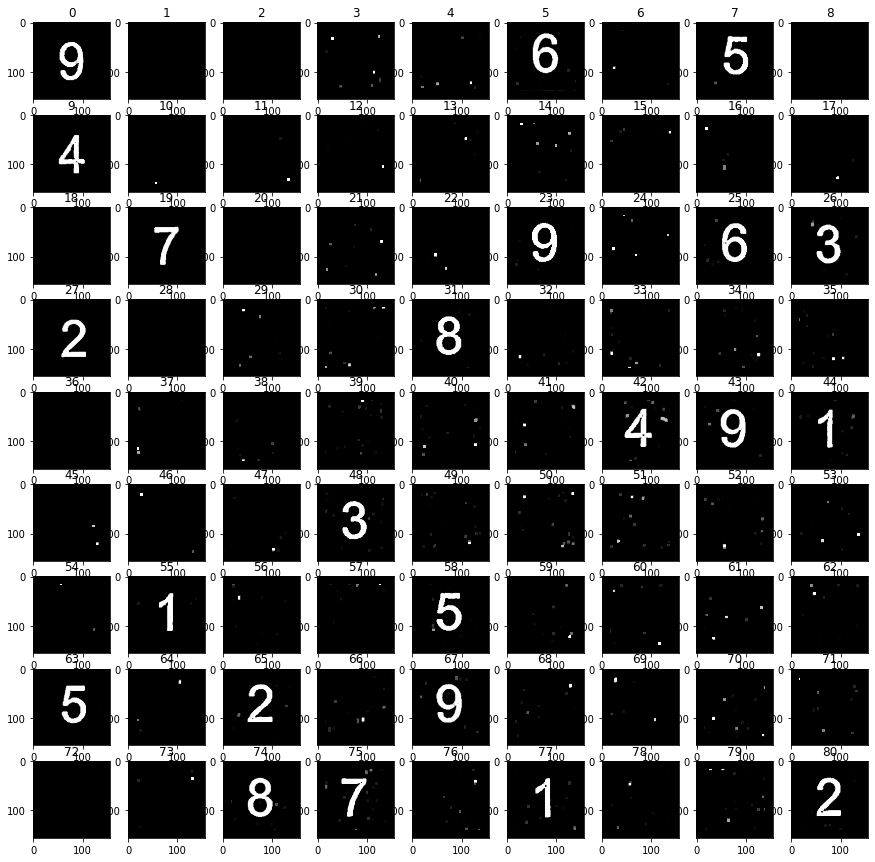

In [7]:
# https://note.nkmk.me/en/python-opencv-numpy-alpha-blend-mask/

mask = np.array(Image.open('mask.png').resize(num[0].shape[1::-1], Image.BILINEAR))
print(mask.shape)

# uint8 (0,255) --> float64 (0.0, 1.0)
mask = mask / 255
print(mask.dtype, mask.min(), mask.max())

dst = np.zeros((81, 156,156), dtype = "float32")

fig = plt.figure(figsize=(15, 15))
for i in range(81):
    dst[i] = num[i] * mask
    plt.subplot(9,9,i+1)
    plt.imshow(dst[i], cmap='gray', interpolation='none')
    plt.title(i)


Efekty usuwania obramowań:

<Figure size 1440x1440 with 0 Axes>

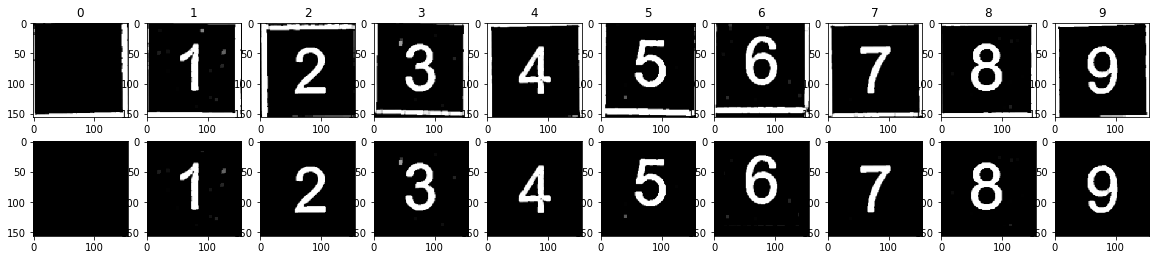

In [8]:
fig = plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 10, figsize=(20,4));

for k, v in no_id.items():
    axs[0, int(k)].set_title(k)
    axs[0, int(k)].imshow(num[v[0]], cmap='gray', interpolation='none')
    axs[1, int(k)].imshow(dst[v[0]], cmap='gray', interpolation='none')

Zapis pozyskanych cyfr do pliku

In [9]:
for k, v in no_id.items():
    path_train = "./data/train/c"+str(k)
    path_test = "./data/test/c"+str(k)
    if not (os.path.exists(path_train) | os.path.exists(path_test)):
        try:
            os.makedirs(path_train)
            os.makedirs(path_test)
        except OSError:
            print('Error!')
    else:
        pass
    i=0
    for item in v:
        im = Image.fromarray(dst[item])
        im = im.convert("L")
        if i == 0:
            f_path_test = os.path.join(path_test, str(item)+'.png')
            im.save(f_path_test)
            i += 1
        else:
            f_path_train = os.path.join(path_train, str(item)+'.png')
            im.save(f_path_train)
        
        #print(item)

## Wygenerowanie dodatkowych danych treningowych - MNIST Way

Kearas umożliwia data augmentation "w locie" ale na początku spróbuję zbudować dataset o takiej strukturze jaką ma MNIST. Pierwszym krokiem będzie wygenerowanie i zapisanie sztucznie stworzonych danych do katalogu preview. 

In [10]:
import os

# Getting the current work directory (cwd)
thisdir =  os.path.join(os.getcwd()+'/data/train/')

files = []
files_dict = {'c0': os.listdir(os.getcwd()+'/data/train/c0'),
              'c1': os.listdir(os.getcwd()+'/data/train/c1'),
              'c2': os.listdir(os.getcwd()+'/data/train/c2'),
              'c3': os.listdir(os.getcwd()+'/data/train/c3'),
              'c4': os.listdir(os.getcwd()+'/data/train/c4'),
              'c5': os.listdir(os.getcwd()+'/data/train/c5'),
              'c6': os.listdir(os.getcwd()+'/data/train/c6'),
              'c7': os.listdir(os.getcwd()+'/data/train/c7'),
              'c8': os.listdir(os.getcwd()+'/data/train/c8'),
              'c9': os.listdir(os.getcwd()+'/data/train/c9'),
             }

print(files_dict)

{'c0': ['2.png', '3.png', '37.png', '4.png', '8.png'], 'c1': ['55.png', '77.png'], 'c2': ['65.png', '80.png'], 'c3': ['48.png'], 'c4': ['42.png'], 'c5': ['58.png', '63.png'], 'c6': ['25.png'], 'c7': ['75.png'], 'c8': ['74.png'], 'c9': ['23.png', '43.png', '67.png']}


In [11]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
            rescale=1./255,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.3,
            rotation_range=3,
            horizontal_flip=False)


def create_images(files_dict):
    for k in files_dict:
        if not os.path.exists('./preview/'+ k +'/'):
            os.mkdir('./preview/'+ k +'/')
            
        for file in files_dict[k]:
            img = load_img('./data/train/'+k+'/'+ file)
            print('./data/train/' + k + '/'+ file)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
            
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='./preview/'+ k +'/', save_prefix='cat', save_format='png'):
                i += 1
                if i > (100 / len(files_dict[k])):
                    break  # otherwise the generator would loop indefinitely

create_images(files_dict)

./data/train/c0/2.png
./data/train/c0/3.png
./data/train/c0/37.png
./data/train/c0/4.png
./data/train/c0/8.png
./data/train/c1/55.png
./data/train/c1/77.png
./data/train/c2/65.png
./data/train/c2/80.png
./data/train/c3/48.png
./data/train/c4/42.png
./data/train/c5/58.png
./data/train/c5/63.png
./data/train/c6/25.png
./data/train/c7/75.png
./data/train/c8/74.png
./data/train/c9/23.png
./data/train/c9/43.png
./data/train/c9/67.png


In [195]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
# https://www.youtube.com/watch?v=Kmypbz3wVko

Wygenerowanie słownika ze wszystkimi elementami

In [12]:
from PIL import Image
im = Image.open('./data/train/c0/2.png')
array = img_to_array(im)
array.shape

(156, 156, 1)

In [13]:
import glob
# filelist = glob.glob('preview/c0/*.png')

f = []
c0 = [0] * 104
c1 = [1] * 102
c2 = [2] * 100
c3 = [3] * 100
c4 = [4] * 101
c5 = [5] * 100
c6 = [6] * 101
c7 = [7] * 101
c8 = [8] * 101
c9 = [9] * 102
c_all = c0 + c1 + c2 + c3 + c4 + c5 + c6 + c7 + c8 +c9
y = np.array(c_all)
for no in range(10):
    filelist = glob.glob(f'preview/c{no}/*.png')
    f += filelist
    print(len(f), no, len(filelist))

    
X = np.array([np.array(Image.open(fname).convert('L')) for fname in f])

104 0 104
206 1 102
306 2 100
406 3 100
507 4 101
607 5 100
708 6 101
809 7 101
910 8 101
1012 9 102


In [14]:
X.shape

(1012, 156, 156)

In [15]:
y[104]

1

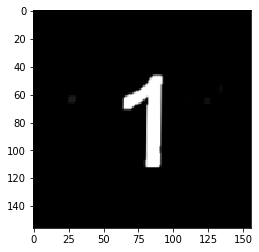

In [16]:
plt.imshow(X[104], cmap='gray');

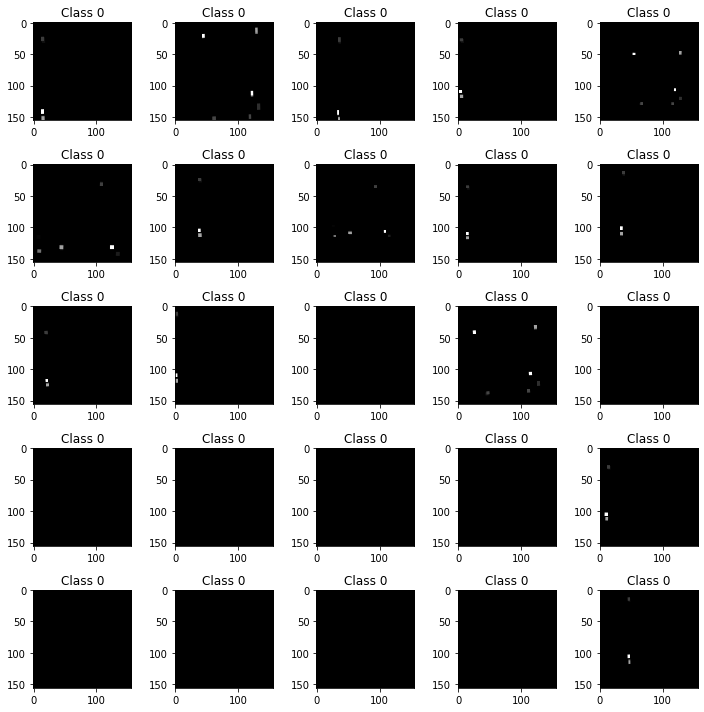

In [17]:
fig = plt.figure(figsize=(10, 10))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.imshow(X[idx], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y[idx]))
    
plt.tight_layout()

In [18]:
# resize & shuffle!
from sklearn.utils import shuffle

X = resize(X, (1012, 28, 28), mode='constant')
X, y = shuffle(X, y)

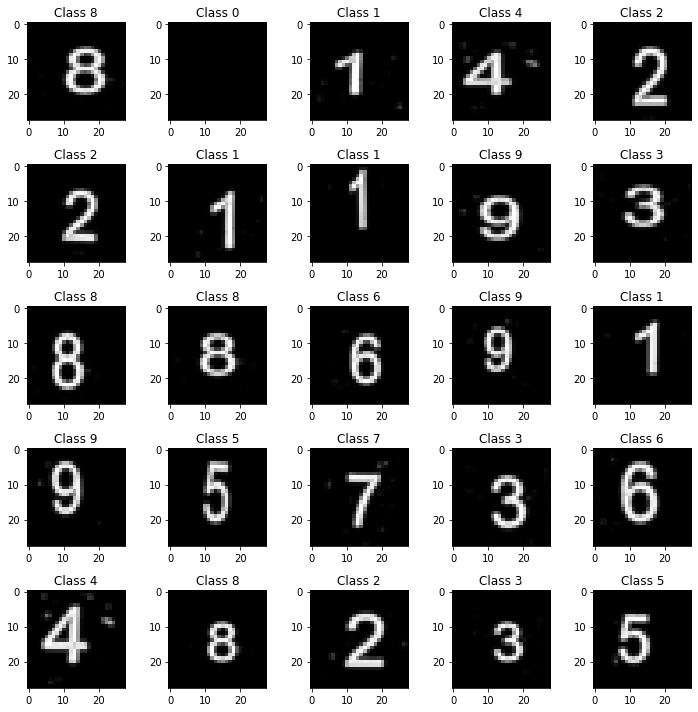

In [19]:
fig = plt.figure(figsize=(10, 10))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.imshow(X[idx], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y[idx]))
    
plt.tight_layout()

In [20]:
X[0:800].shape

X_train = X[0:800]
y_train = y[0:800] 
X_test = X[800:] 
y_test = y[800:] 

In [21]:
y_train.shape

(800,)

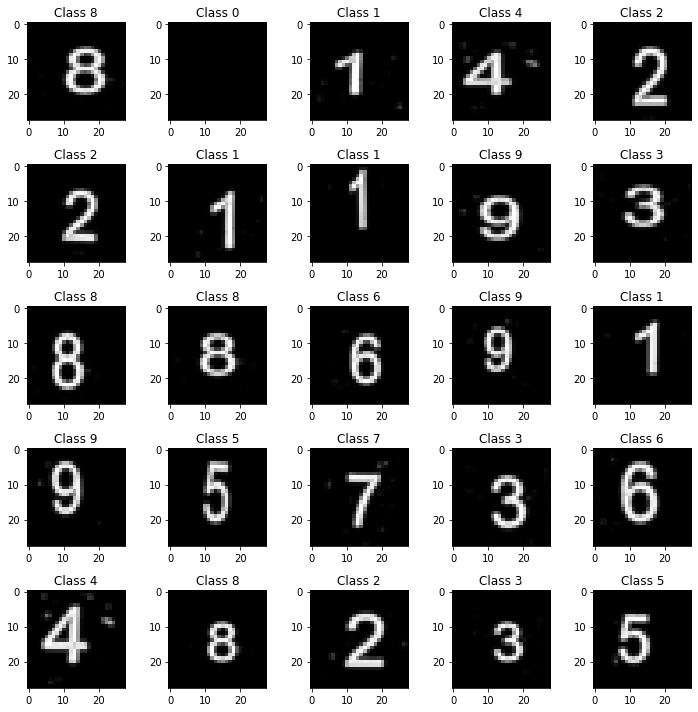

In [22]:
fig = plt.figure(figsize=(10, 10))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.imshow(X_train[idx], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[idx]))
    
plt.tight_layout()

In [23]:
X_train.shape

(800, 28, 28)

In [24]:
X_train.shape

(800, 28, 28)

In [25]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_last':
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
else:
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    
print(X_train.shape, X_test.shape)

(800, 28, 28, 1) (212, 28, 28, 1)


Number: 4


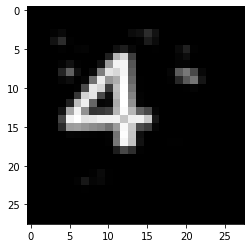

In [26]:
num = 101

t = X_train[num].reshape(28,28)
print('Number:', y_train[num])
plt.imshow(t, cmap='gray');

In [27]:
# normalizacja danych
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

num_classes = 10

# one-hot encoding dla zmiennej docelowej
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [28]:
def get_simple_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 
        
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(), # spłaszczanie danych, aby połączyć warstwy konwolucyjne z fully connected layers
        
        Dense(1024, activation='relu'),
        Dropout(0.25),
        Dense(num_classes, activation='softmax')
    ])

get_simple_cnn().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

In [29]:
model = get_simple_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

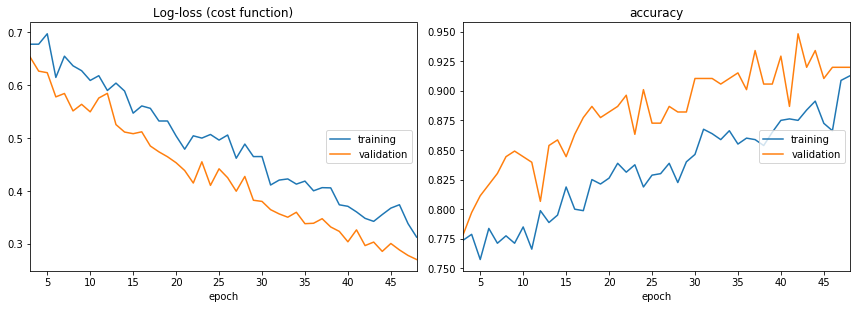

Log-loss (cost function):
training   (min:    0.312, max:    0.724, cur:    0.312)
validation (min:    0.270, max:    0.653, cur:    0.270)

accuracy:
training   (min:    0.733, max:    0.913, cur:    0.913)
validation (min:    0.778, max:    0.948, cur:    0.920)
800/800 - 1s - loss: 0.3124 - accuracy: 0.9125 - val_loss: 0.2700 - val_accuracy: 0.9198


In [36]:
plot_losses = PlotLossesCallback()

history = model.fit(X_train, y_train,
  batch_size=128, epochs=48,
  verbose=2,
  callbacks=[plot_losses],
  validation_data=(X_test, y_test)
)

In [37]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.26998165249824524
Test accuracy: 0.9198113
CNN Error: 8.02%


In [38]:
y_pred = model.predict(X_test)

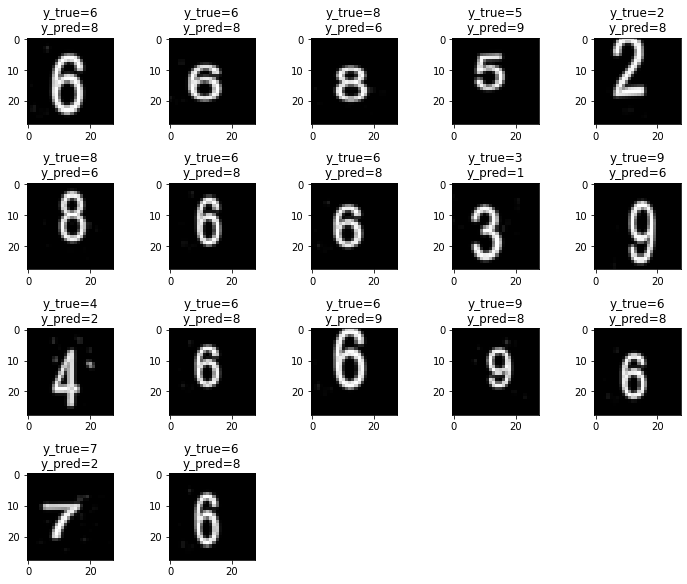

In [39]:
def get_diff(y_test, y_pred):
    for idx, (a, b) in enumerate(zip(y_test, y_pred)):
        if np.argmax(a) == np.argmax(b): continue
        yield idx, np.argmax(a), np.argmax(b)

limit = 20
cur_limit = 0
fig = plt.figure(figsize=(10, 10))
X_test_plot = X_test.reshape( X_test.shape[:-1] )

for it, (idx, y_test_val, y_pred_val) in enumerate(get_diff(y_test, y_pred)):
    if cur_limit > limit: break
      
    plt.subplot(5,5,it+1)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true={0}\ny_pred={1}'.format(y_test_val, y_pred_val))
    plt.tight_layout()
        
    cur_limit += 1

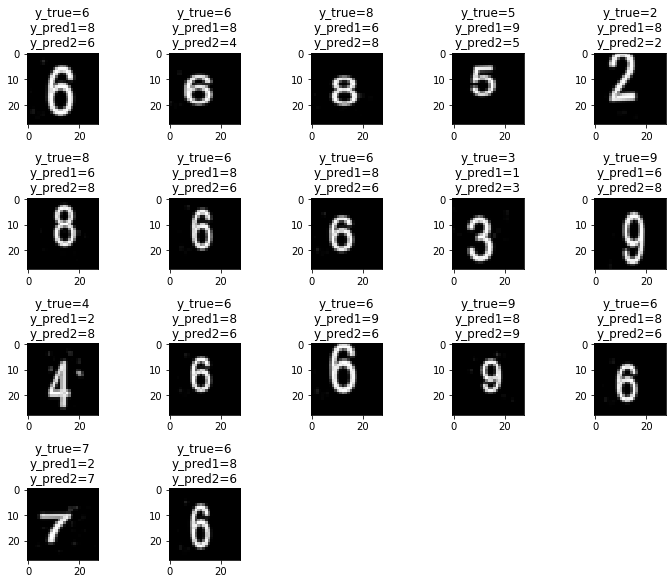

In [40]:
def get_diff2(y_test, y_pred):
    for idx, (a, b) in enumerate(zip(y_test, y_pred)):
        if np.argmax(a) == np.argmax(b): continue
        #print(idx, np.argmax(a), np.argmax(b), np.argsort(b)[-2])
        yield idx, np.argmax(a), np.argmax(b), np.argsort(b)[-2]
        
limit = 24
cur_limit = 0
fig = plt.figure(figsize=(10, 10))
X_test_plot = X_test.reshape( X_test.shape[:-1] )

for it, (idx, y_test_val, y_pred_val, y_pred_val2) in enumerate(get_diff2(y_test, y_pred)):
    #print(it, "->", y_test_val, y_pred_val, y_pred_val2)      
    if cur_limit > limit: break
      
    plt.subplot(5,5,it+1)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true={0}\ny_pred1={1}\ny_pred2={2}'.format(y_test_val, y_pred_val,y_pred_val2))
    plt.tight_layout()
        
    cur_limit += 1

# Wygenerowanie dodatkowych danych treningowych 

In [28]:
# https://github.com/dataworkshop/dw-poznan-project/tree/master/spotkania/2020-06-04

In [155]:
def show_sample(x,y, n=16):
    size = int(n**.5)
    i = 0;
    fig, axs = plt.subplots(size, size)
    for ax in range(size):
        for ay in range(size):
            ax1 = axs[ax,ay]
            ax1.figure.set_size_inches(15, 15)
            ax1.imshow(x[i])
            ax1.set_title(y[i])
            ax1.axis('off')
            i += 1;
            if(i>16):
                break
    plt.show()

In [156]:
PATH = r'D:\Github\py_sudoku'
train_dir = os.path.join(PATH, r'data\train')
validation_dir = os.path.join(PATH, r'data\test')
print(train_dir ,validation_dir, sep='\n')

D:\Github\py_sudoku\data\train
D:\Github\py_sudoku\data\test


In [157]:
def get_train_val(datagen, batch_size=64):
    return (datagen.flow_from_directory(train_dir, class_mode='categorical', batch_size=64), 
          datagen.flow_from_directory(validation_dir, class_mode='categorical', batch_size=64))

In [159]:
train_it, val_it = get_train_val(ImageDataGenerator(
                                    rescale=1./255,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.3,
                                    rotation_range=3,
                                    horizontal_flip=False))

Found 19 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


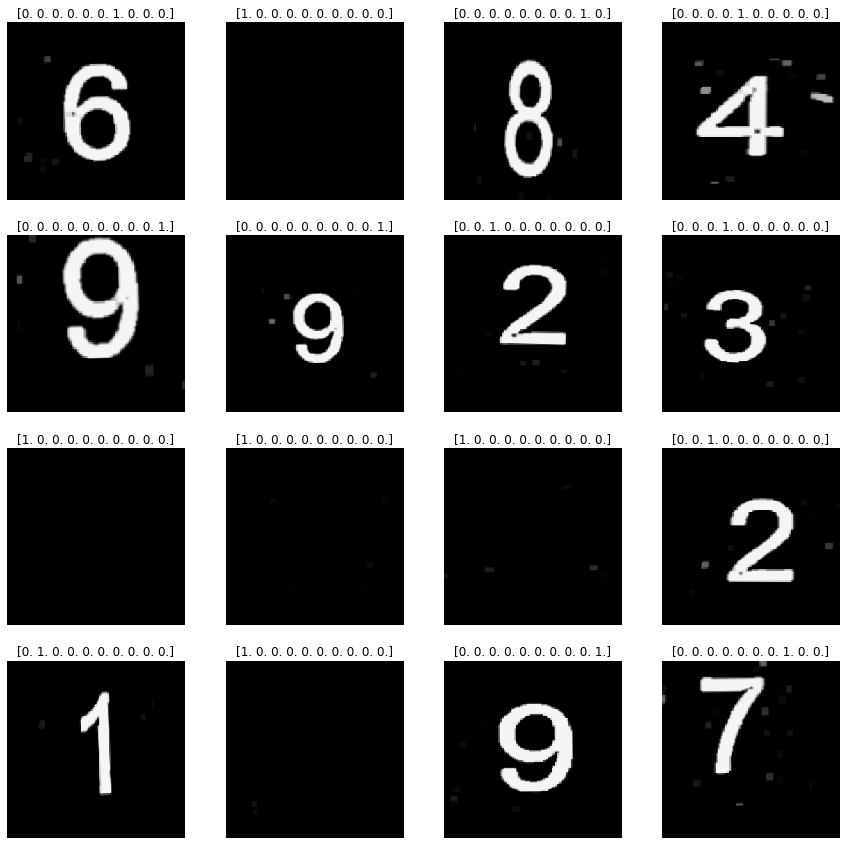

In [160]:
x,y = train_it.next()
show_sample(x,y)

In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)

def get_model(x):
    IMG_WIDTH =  x[0].shape[0]
    IMG_HEIGHT = x[0].shape[0]
    
    num_classes = 10

#     # one-hot encoding dla zmiennej docelowej
#     y_train = to_categorical(y_train)
#     y_test = to_categorical(y_test)
    
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 
        
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(), # spłaszczanie danych, aby połączyć warstwy konwolucyjne z fully connected layers
        
        Dense(1024, activation='relu'),
        Dropout(0.25),
        Dense(num_classes, activation='softmax')
    ])
    
# model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  
#     model = Sequential([
#         Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
#         MaxPooling2D(),
#         Conv2D(32, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
#         Conv2D(64, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
#         Flatten(),
#         Dense(512, activation='relu'),
#         Dense(1)
#       ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    print(model.summary())
    return model

Tensorflow version:  2.1.0


In [162]:
model = get_model(x)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 246016)          

In [163]:
history = model.fit(
    train_it,
    epochs=10,
    validation_data=val_it
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/10
1/1 [==============================] - 18s 18s/step - loss: 2.3025 - accuracy: 0.1579 - val_loss: 2.2612 - val_accuracy: 0.2000
Epoch 2/10
1/1 [==============================] - 9s 9s/step - loss: 2.2617 - accuracy: 0.1579 - val_loss: 2.3340 - val_accuracy: 0.2000
Epoch 3/10
1/1 [==============================] - 19s 19s/step - loss: 2.1563 - accuracy: 0.5263 - val_loss: 2.3343 - val_accuracy: 0.2000
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 2.2570 - accuracy: 0.4211 - val_loss: 2.2423 - val_accuracy: 0.3000
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 2.1742 - accuracy: 0.4211 - val_loss: 2.3701 - val_accuracy: 0.1000
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 2.0576 - accuracy: 0.4211 - val_loss: 2.2610 - val_accuracy: 0.2000
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 2.0194 - accura

---

# XXX

---

Dane w zbiorze MNIST są przechowywane w zbiorze X i y

- X: wektor 784 px (liczba zapisana w sposób płaski)
- y: wektor przwdopodobieństwa z numerem cyfry np: `[0,0,0,0,0,0,1,0,0]`

In [11]:
# https://medium.com/@florestony5454/median-filtering-with-python-and-opencv-2bce390be0d1

In [ ]:
# https://medium.com/@o.kroeger/tensorflow-mnist-and-your-own-handwritten-digits-4d1cd32bbab4
# https://www.youtube.com/watch?v=oKzNUGz21JM
# https://stackoverflow.com/questions/39289285/how-to-create-a-image-dataset-just-like-mnist-dataset
# https://stackoverflow.com/questions/46555025/making-your-own-set-of-mnist-data-identical-to-mnist-format
# https://www.quora.com/How-do-I-create-a-dataset-like-MNIST-for-recognizing-another-language-characters-I-have-dataset-as-a-folder-of-images-How-do-I-use-that-in-Tensorflow

### Data augmentation

In [ ]:
# https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
# https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist

Preds:  9
Prob: [0.0000000e+00 4.9143300e-30 1.5472257e-28 1.5508456e-31 2.4401272e-18
 1.6752881e-27 2.6684524e-15 0.0000000e+00 6.0405681e-19 1.0000000e+00]
P: [0.0000000e+00 4.9143300e-30 1.5472257e-28 1.5508456e-31 2.4401272e-18
 1.6752881e-27 2.6684524e-15 0.0000000e+00 6.0405681e-19 1.0000000e+00]
0 1
1 1
2 2
3 9
4 1
5 9
6 9
7 1
8 9
9 9


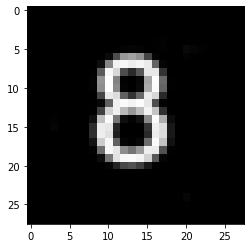

In [504]:
imgg = resize(dst, (81,28, 28), mode='constant')
imgg = imgg.reshape(81,784)


    
no = 31

preds = model.predict_classes(imgg)
prob = model.predict_proba(imgg)
p = model.predict(imgg)
print('Preds: ', preds[no])
print('Prob:', prob[no])
print('P:', p[no])

test_img = imgg[no]
t = test_img.reshape(28,28)
plt.imshow(t, cmap='gray');

for k, v in no_id.items():
    print(k,preds[v[0]])

## CNN

In [495]:
cmodel.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [497]:
cmodel.fit(cX_train, cy_train,
  batch_size=256, epochs=8,
  verbose=2,
#   callbacks=[plot_losses],
  validation_data=(cX_test, cy_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 - 42s - loss: 0.3036 - accuracy: 0.9047 - val_loss: 0.0641 - val_accuracy: 0.9796
Epoch 2/8
60000/60000 - 43s - loss: 0.0859 - accuracy: 0.9731 - val_loss: 0.0442 - val_accuracy: 0.9855
Epoch 3/8
60000/60000 - 48s - loss: 0.0620 - accuracy: 0.9807 - val_loss: 0.0339 - val_accuracy: 0.9887
Epoch 4/8
60000/60000 - 53s - loss: 0.0492 - accuracy: 0.9842 - val_loss: 0.0269 - val_accuracy: 0.9909
Epoch 5/8
60000/60000 - 55s - loss: 0.0416 - accuracy: 0.9868 - val_loss: 0.0236 - val_accuracy: 0.9918
Epoch 6/8
60000/60000 - 54s - loss: 0.0348 - accuracy: 0.9890 - val_loss: 0.0252 - val_accuracy: 0.9910
Epoch 7/8
60000/60000 - 45s - loss: 0.0339 - accuracy: 0.9889 - val_loss: 0.0230 - val_accuracy: 0.9925
Epoch 8/8
60000/60000 - 44s - loss: 0.0312 - accuracy: 0.9899 - val_loss: 0.0223 - val_accuracy: 0.9926


In [498]:
score = cmodel.evaluate(cX_test, cy_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.022307764142373343
Test accuracy: 0.9926
CNN Error: 0.74%


Preds:  7
Prob: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
P: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0 1
1 1
2 2
3 3
4 4
5 5
6 9
7 7
8 9
9 9


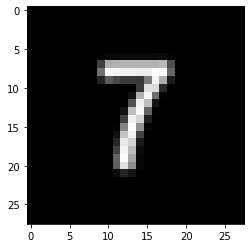

In [505]:
imgg = resize(dst, (81,28, 28), mode='constant')
imgg = imgg.reshape(81,28,28,1)

no = 19

preds = cmodel.predict_classes(imgg)
prob = cmodel.predict_proba(imgg)
p = cmodel.predict(imgg)
print('Preds: ', preds[no])
print('Prob:', prob[no])
print('P:', p[no])

test_img = imgg[no]
t = test_img.reshape(28,28)
plt.imshow(t, cmap='gray');

for k, v in no_id.items():
    print(k,preds[v[0]])

---

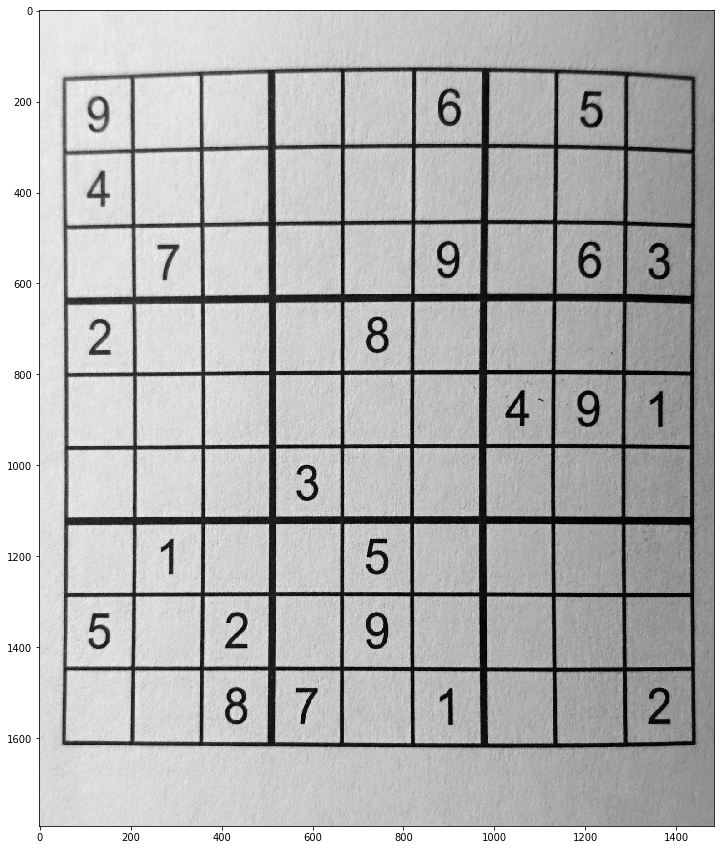

In [214]:
def preprocessImg(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #gray = cv2.GaussianBlur(gray, (11, 11), 0)
    plt.figure(figsize=(15,15))
    plt.imshow(gray, cmap='gray');

image = cv2.imread('1.jpg')
preprocessImg(image)

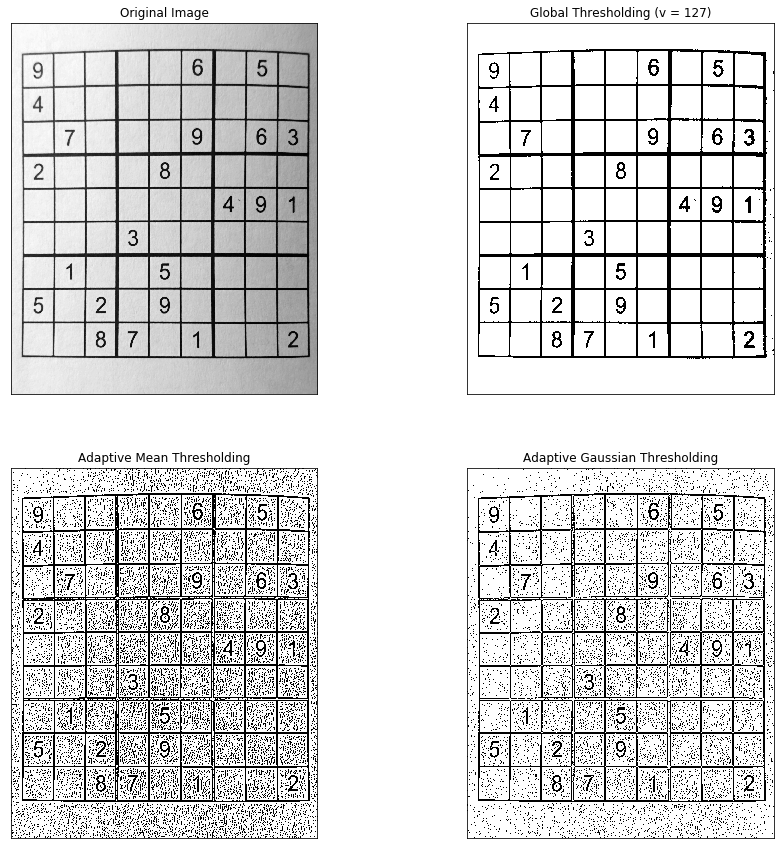

In [23]:
img = cv2.imread('1.jpg',0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,130,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

plt.figure(figsize=(15,15))

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

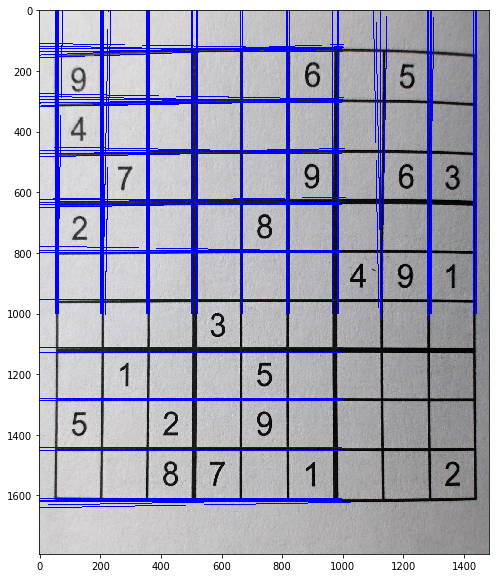

In [13]:
img = cv2.imread(cv2.samples.findFile('1.jpg'))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
lines = cv2.HoughLines(edges,1,np.pi/180,200)
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
cv2.imwrite('houghlines3.jpg',img)

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray');

In [17]:
def remove_isolated_pixels(image):
    connectivity = 8

    output = cv2.connectedComponentsWithStats(image, connectivity, cv2.CV_32S)

    num_stats = output[0]
    labels = output[1]
    stats = output[2]

    new_image = image.copy()

    for label in range(num_stats):
        if stats[label,cv2.CC_STAT_AREA] == 1:
            new_image[labels == label] = 0
    return new_image

img = cv2.imread('output.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
p = remove_isolated_pixels(gray)



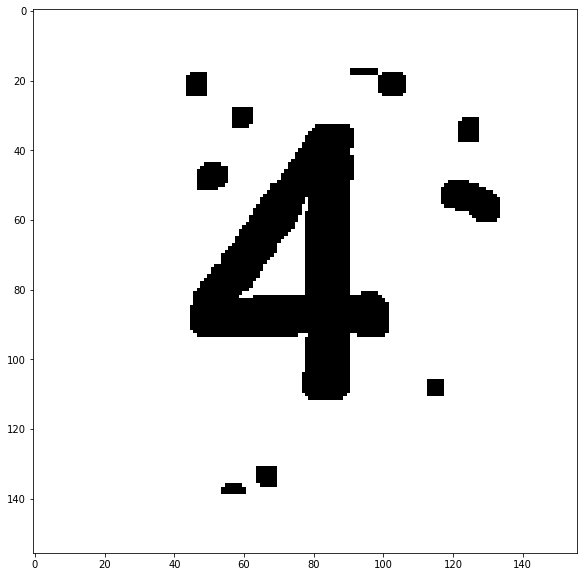

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(p, cmap='gray');

In [ ]:

img = cv2.imread('output.png', 0 )
img_inv = cv2.bitwise_not( img )

#cv2.imshow( 'Black-on-White', img )
#cv2.waitKey(0)

#cv2.imshow( 'White-on-Black', img_inv )
#cv2.waitKey(0)

bw_nlbls, bw_lbls, bw_stats, _ = cv2.connectedComponentsWithStats( img )
wb_nlbls, wb_lbsl, wb_stats, _ = cv2.connectedComponentsWithStats( img_inv )

bw = 'Black-On-White'
wb = 'White-On-Black'

print( bw )
print( '-'*len(bw) )
print()
print('Number of Components: ', bw_nlbls)
print()
print( wb )
print( '-'*len(wb) )
print()
print('Number of Components: ', wb_nlbls)

In [17]:
#  https://www.domoritz.de/blog/2016/08/simple-sudoku-solver.html


field = [
    [9,0,0,0,0,6,0,5,0],
    [4,0,0,0,0,0,0,0,0],
    [0,7,0,0,0,9,0,6,3],
    [2,0,0,0,8,0,0,0,0],
    [0,0,0,0,0,0,4,9,1],
    [0,0,0,3,0,0,0,0,0],
    [0,1,0,0,5,0,0,0,0],
    [5,0,2,0,9,0,0,0,0],
    [0,0,8,7,0,1,0,0,2]]

In [2]:
import cv2
import numpy as np

# Read the image
img = cv2.imread('borders2.png')

# Get image shape
h, w, channels = img.shape

# Draw a rectangle on the border to combine the wall to one contour
cv2.rectangle(img,(0,0),(w,h),(0,0,0),2)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply binary threshold
_, threshold = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

# Search for contours and sort them by size
contours, hierarchy = cv2.findContours(threshold,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
area = sorted(contours, key=cv2.contourArea, reverse=True)

print(*area)

# # Draw it out with white color from biggest to second biggest contour
# cv2.drawContours(img, ((contours[0]),(contours[1])), -1, (255,255,255), -1)

# # Apply binary threshold again to the new image to remove little noises
# _, img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)

# # Display results
# # cv2.imshow('img', img)

# plt.figure(figsize=(10,10))
# plt.imshow(img, cmap='gray');

[[[0 0]]

 [[0 1]]

 [[0 2]]

 ...

 [[3 0]]

 [[2 0]]

 [[1 0]]] [[[25  4]]

 [[26  3]]

 [[27  3]]

 ...

 [[23  5]]

 [[24  5]]

 [[25  5]]] [[[225  20]]

 [[225  21]]

 [[225  22]]

 [[225  23]]

 [[224  24]]

 [[223  24]]

 [[223  25]]

 [[222  26]]

 [[221  26]]

 [[221  27]]

 [[220  28]]

 [[219  28]]

 [[219  29]]

 [[218  30]]

 [[217  30]]

 [[216  30]]

 [[215  30]]

 [[215  31]]

 [[214  32]]

 [[213  32]]

 [[212  32]]

 [[211  32]]

 [[211  33]]

 [[211  34]]

 [[211  35]]

 [[211  36]]

 [[211  37]]

 [[211  38]]

 [[211  39]]

 [[212  40]]

 [[213  39]]

 [[213  38]]

 [[214  37]]

 [[215  37]]

 [[215  36]]

 [[216  35]]

 [[217  35]]

 [[218  35]]

 [[219  35]]

 [[219  34]]

 [[220  33]]

 [[221  33]]

 [[222  33]]

 [[223  33]]

 [[224  33]]

 [[225  34]]

 [[225  35]]

 [[224  36]]

 [[223  36]]

 [[223  37]]

 [[223  38]]

 [[223  39]]

 [[223  40]]

 [[223  41]]

 [[223  42]]

 [[223  43]]

 [[223  44]]

 [[223  45]]

 [[223  46]]

 [[223  47]]

 [[223  48]]

 [